In [1]:
import sqlite3
import os
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show as rastershow
from rasterio import mask
from shapely.geometry import Point, Polygon, box
import shapely
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
rastertif = rasterio.open('/home/k/k202141/workdir/shared_data/2024-ufz-deeptree/example_tiles/LVermGeo_DOP20/dop20rgbi_32_704_5708_2_st_2022.tif')
output_dir = '/work/ka1176/caroline/gitlab/TreeCrownDelineation/scripts/output/'

In [3]:
dbfiles = [os.path.join(output_dir, f'result_{exp}.sqlite') for exp in ['A', 'B', 'C', 'D', 'E']] # problem with B
cols = [f'result_{exp}' for exp in ['a', 'b', 'c', 'd', 'e']]

In [4]:
geoms = []
for dbfile, col in zip(dbfiles, cols):
    print(dbfile)
    con = sqlite3.connect(dbfile)
    cur = con.cursor()
    
    df = pd.read_sql_query(f"SELECT * from {col}", con)
    con.close()
    geo = gpd.GeoSeries.from_wkb(df['GEOMETRY']).to_frame(f'geometry')
    geo['experiment'] = col
    geoms.append(geo)

/work/ka1176/caroline/gitlab/TreeCrownDelineation/scripts/output/result_A.sqlite
/work/ka1176/caroline/gitlab/TreeCrownDelineation/scripts/output/result_B.sqlite
/work/ka1176/caroline/gitlab/TreeCrownDelineation/scripts/output/result_C.sqlite
/work/ka1176/caroline/gitlab/TreeCrownDelineation/scripts/output/result_D.sqlite
/work/ka1176/caroline/gitlab/TreeCrownDelineation/scripts/output/result_E.sqlite


In [5]:
geoframe = pd.concat(geoms)
geoframe.crs = 25832
geoframe = geoframe.to_crs(epsg=25832) # fix coordinate system

In [6]:
geoframe

geometry experiment
0      POLYGON ((705835.5 5709999.9, 705836.7 5709998...   result_a
1      POLYGON ((704473.5 5709999.9, 704473.5 5709997...   result_a
2      POLYGON ((704394.3 5709999.9, 704394.9 5709997...   result_a
3      POLYGON ((704611.7 5709999.9, 704611.7 5709999...   result_a
4      POLYGON ((705004.9 5709999.9, 705005.9 5709998...   result_a
...                                                  ...        ...
19834  POLYGON ((704959.7 5708004.9, 704958.1 5708003...   result_e
19835  POLYGON ((704968.9 5708002.3, 704966.5 5708000...   result_e
19836  POLYGON ((705431.5 5708009.7, 705430.3 5708008...   result_e
19837  POLYGON ((705721.5 5708006.5, 705719.3 5708004...   result_e
19838  POLYGON ((705748.5 5708004.3, 705746.7 5708002...   result_e

[122388 rows x 2 columns]

In [7]:
# add Baumkataster trees
ground_truth = gpd.read_file('/home/k/k202141/workdir/shared_data/2024-ufz-deeptree/halle-baumkataster/itc005211130105323_point.shp')
ground_truth = ground_truth.to_crs(epsg=25832) # need this in the same coordinate system

In [8]:
rastertif.bounds

BoundingBox(left=704000.0, bottom=5708000.0, right=706000.0, top=5710000.0)

## visualize smaller region

In [9]:
# zoom in on a smaller region for better visibility
zoom_box = {'left':705000, 'right':705250, 'bottom':5709000, 'top':5709250}

In [10]:
zbox = Polygon( (Point(zoom_box['left'], zoom_box['bottom']), Point(zoom_box['right'], zoom_box['bottom']), Point(zoom_box['right'], zoom_box['top']), Point(zoom_box['left'], zoom_box['top']), ) )
zoom_ground_truth = ground_truth[ground_truth.within(zbox)]
zoom_geoframe = geoframe[geoframe.within(zbox)]
zoom_tif, _ = rasterio.mask.mask(rastertif, [zbox], crop=True)

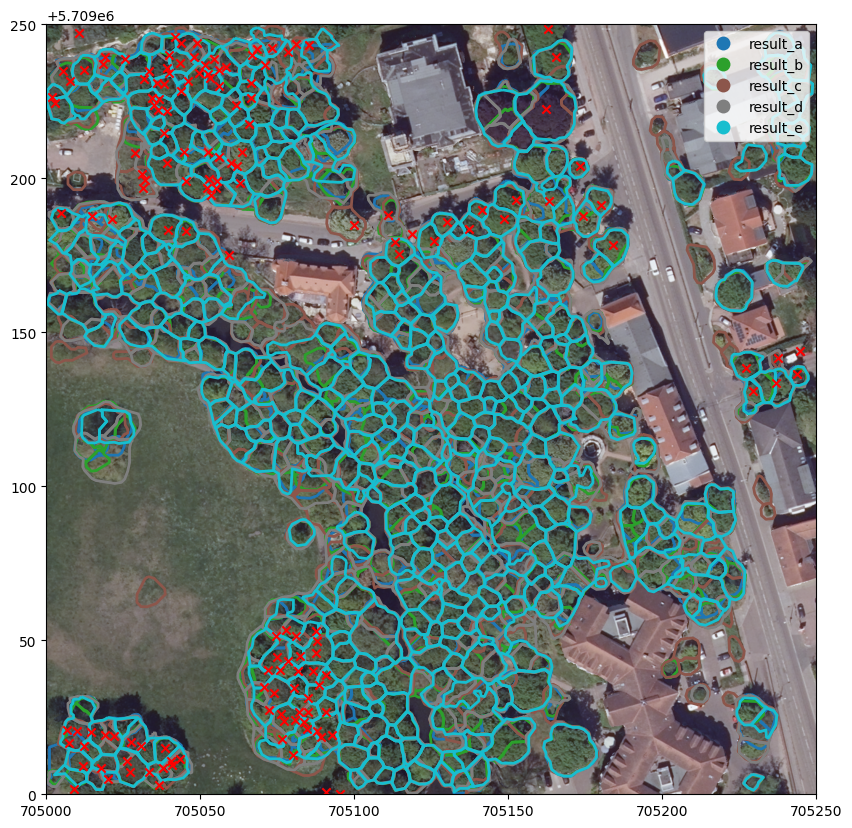

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#rastershow(zoom_tif, ax=ax)
ax.imshow(zoom_tif[:3].swapaxes(0,1).swapaxes(1,2), extent=[x[1] for x in zoom_box.items()])
zoom_geoframe.plot(ax=ax, column='experiment', facecolor='none', legend=True, lw=2)
zoom_ground_truth.plot(ax=ax, marker='x', color='red')
plt.show()

## calculate metrics

In [12]:
# restrict baumkataster ground truth to patch
ground_truth = ground_truth[ground_truth.within(box(*rastertif.bounds))]

In [13]:
for i, exp in enumerate(['result_' + x for x in ['a', 'b', 'c', 'd', 'e']]):
    intersection = geoframe.query('experiment==@exp').sjoin(ground_truth)
    intersection_rows = len(intersection)
    ground_truth_rows = len(ground_truth)
    print(f'Model {i} ({exp}): found {intersection_rows} / {ground_truth_rows} trees ({100*intersection_rows/ground_truth_rows:.2f}%)')

Model 0 (result_a): found 2533 / 4024 trees (62.95%)
Model 1 (result_b): found 2622 / 4024 trees (65.16%)
Model 2 (result_c): found 3104 / 4024 trees (77.14%)
Model 3 (result_d): found 3019 / 4024 trees (75.02%)
Model 4 (result_e): found 2513 / 4024 trees (62.45%)


## difference in model predictions

In [14]:
all_segments = {}

for i, exp in enumerate(['result_' + x for x in ['a', 'b', 'c', 'd', 'e']]):
    this_geodf = geoframe.query('experiment==@exp')
    print(f'Model {i} ({exp}): found {len(this_geodf)} trees')
    print(f'Zooming in ...')
    all_segments[exp] = this_geodf[this_geodf.within(zbox)].union_all()

Model 0 (result_a): found 21960 trees
Zooming in ...
Model 1 (result_b): found 25553 trees
Zooming in ...
Model 2 (result_c): found 28349 trees
Zooming in ...
Model 3 (result_d): found 26687 trees
Zooming in ...
Model 4 (result_e): found 19839 trees
Zooming in ...


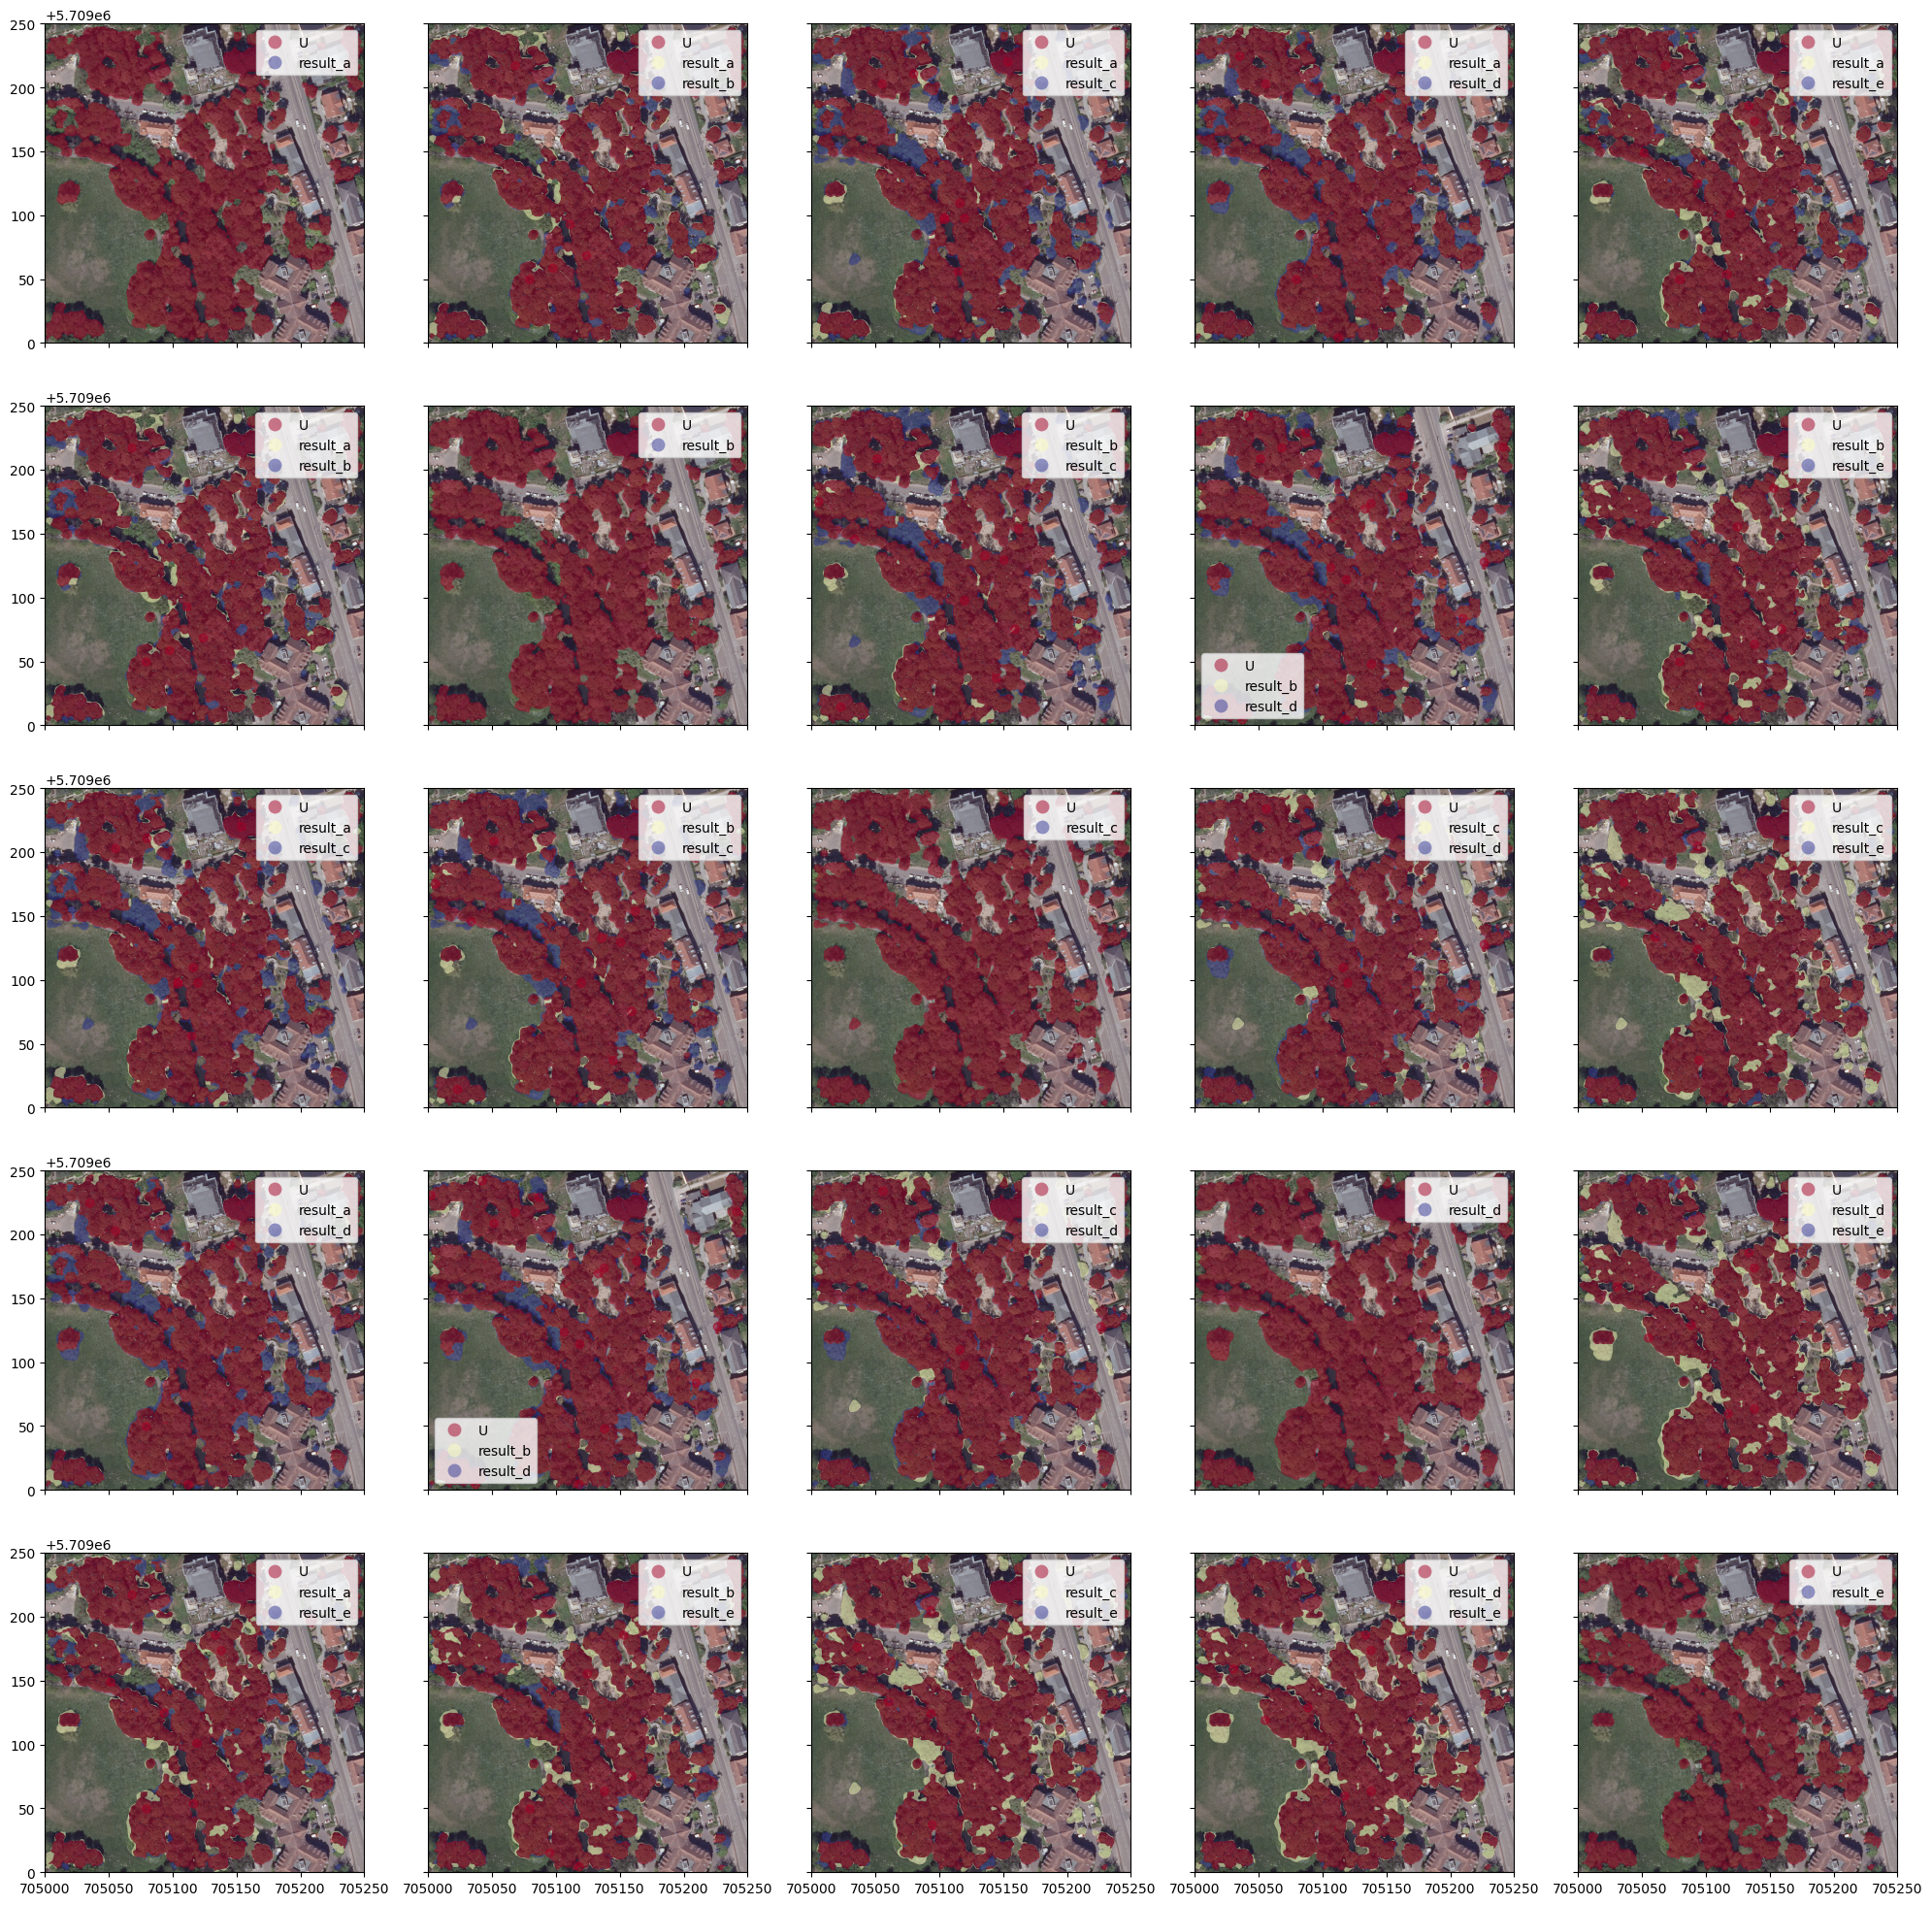

In [15]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(20, 20))

for i, exp1 in enumerate(['result_' + x for x in ['a', 'b', 'c', 'd', 'e']]):
    for j, exp2 in enumerate(['result_' + x for x in ['a', 'b', 'c', 'd', 'e']]):
        geom_inter = shapely.intersection(all_segments[exp1], all_segments[exp2])
        geom_diff1 = shapely.difference(all_segments[exp1], all_segments[exp2])
        geom_diff2 = shapely.difference(all_segments[exp2], all_segments[exp1])
        
        tmp = gpd.GeoDataFrame(dict(geometry=[geom_inter, geom_diff1, geom_diff2], label=['U', exp1, exp2]))
        tmp.plot(ax=ax[i,j], column='label', legend=True, cmap='RdYlBu', alpha=0.5)
        ax[i,j].imshow(zoom_tif[:3].swapaxes(0,1).swapaxes(1,2), extent=[x[1] for x in zoom_box.items()])

fig.tight_layout()

In [16]:
# TODO polygon-wise union ??

## what sets the detected trees apart?

In [17]:
intersection.head()

geometry experiment  \
67   POLYGON ((705467.3 5709999.9, 705467.5 5709997...   result_e   
89   POLYGON ((705441.3 5709999.9, 705441.3 5709998...   result_e   
91   POLYGON ((705352.7 5709999.9, 705353.3 5709998...   result_e   
98   POLYGON ((705090.3 5709995.9, 705091.3 5709992...   result_e   
107  POLYGON ((705209.1 5709999.9, 705209.9 5709997...   result_e   

     index_right           standort  hoehe_m baum_nr krone_m  stammu_cm  \
67         30140  Reichardts Garten  11 - 15      57  6 - 10       80.0   
89         34753  Reichardts Garten     > 20      76  6 - 10      140.0   
91         25547  Reichardts Garten     > 20     418  6 - 10      146.0   
98         20853         Amtsgarten  16 - 20     314  6 - 10       99.0   
107         2208         Amtsgarten    2 - 5     109    None       18.0   

           art_deu    gid  pflanzjahr           art_botan strasse  
67     Spitz-Ahorn  66508         NaN    Acer platanoides    None  
89     Spitz-Ahorn  66527         NaN    Acer platanoides    None  
91    Winter-Linde  66883         NaN       Tilia cordata    None  
98   Gemeine Esche  44845         NaN  Fraxinus excelsior    None  
107     Ginkgobaum  65707         NaN    Ginkgo biloba L.    None

The trees that are recognized are on average larger and older

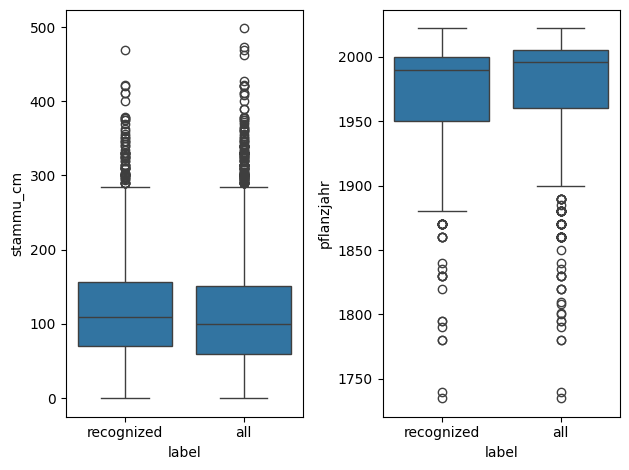

In [18]:
fig, ax = plt.subplots(1, 2)

for i, feature in enumerate(['stammu_cm', 'pflanzjahr']):
    tmp = pd.DataFrame(dict(value=list(intersection[feature].values) + list(ground_truth[feature].values), label=['recognized']*len(intersection) + ['all']*len(ground_truth)))
    sns.boxplot(data=tmp, x='label', y='value', ax=ax[i])
    ax[i].set_ylabel(feature)
fig.tight_layout()

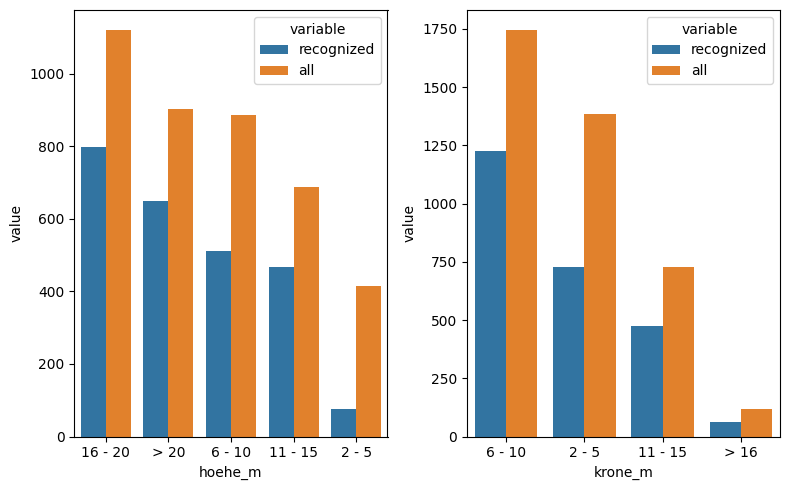

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

for i, feature in enumerate(['hoehe_m', 'krone_m']):

    tmp = pd.melt(pd.merge(intersection[feature].value_counts().to_frame('recognized').reset_index(), ground_truth[feature].value_counts().to_frame('all').reset_index()), id_vars=feature)
    sns.barplot(data=tmp, x=feature, y='value', hue='variable', ax=ax[i])

fig.tight_layout()